# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('font', **{'size': 12}) # Text more readable

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Our first goal is to plot the evolution of the number of beehives per continent. For this purpose, we use the dataset from FAOSTAT, that lists the number of beehives per country from 1961.

In [2]:
beehives_raw = pd.read_csv('data/FAOSTAT_Live_Stock.csv')
beehives_raw.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1961,1961,No,95100.0,NaN,Official data
1,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1962,1962,No,92800.0,NaN,Official data
2,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1963,1963,No,83500.0,NaN,Official data
3,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1964,1964,No,96500.0,NaN,Official data
4,QA,Live Animals,3,Albania,5114,Stocks,1181,Beehives,1965,1965,No,109800.0,NaN,Official data


Let's only select the columns that interest us, i.e. everythin apart from the country, the year and the number of beehives.

In [3]:
beehives_raw = beehives_raw[['Area', 'Year', 'Value']]
beehives_raw.head()

,Area,Year,Value
0,Albania,1961,95100.0
1,Albania,1962,92800.0
2,Albania,1963,83500.0
3,Albania,1964,96500.0
4,Albania,1965,109800.0


Then, let's import a small dataset that lists all the countries in the world to their respective continents. The csv file was [found here](https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv).

In [4]:
countries = pd.read_csv('data/countries.csv')
# We only want the name of the country and its continent
countries = countries[['name', 'region']]
countries = countries.set_index('name')
print('Are the countries in the dataset unique? -> %s' % countries.index.is_unique)
countries.head()

Are the countries in the dataset unique? -> True


,region
name,
Afghanistan,Asia
Åland Islands,Europe
Albania,Europe
Algeria,Africa
American Samoa,Oceania


The `countries` dataset does not have data from certain countries present in the FAOSTAT dataset. These countries have either ceased to exist (USSR, Yugoslavia, ...), or were defined differently (China, mainland, ...).

In [5]:
countries.loc['Belgium-Luxembourg'] = 'Europe'
countries.loc['China, mainland'] = 'Asia'
countries.loc['China, Taiwan Province of'] = 'Asia'
countries.loc['Czechoslovakia'] = 'Europe'
countries.loc['Ethiopia PDR'] = 'Africa'
countries.loc['Palestine'] = 'Asia'
countries.loc['Republic of Korea'] = 'Asia'
countries.loc['Republic of Moldova'] = 'Europe'
countries.loc['Serbia and Montenegro'] = 'Europe'
countries.loc['Sudan (former)'] = 'Africa'
countries.loc['United Kingdom'] = 'Europe'
countries.loc['United Republic of Tanzania'] = 'Africa'
countries.loc['USSR'] = 'Europe'
countries.loc['Wallis and Futuna Islands'] = 'Oceania'
countries.loc['Yugoslav SFR'] = 'Europe'

countries['region'].value_counts()

Africa      63
Europe      58
Americas    57
Asia        55
Oceania     30
Name: region, dtype: int64

We indeed verify that all 5 continents are present.

Then, we add the continent as a column in our beehive dataset.

In [6]:
beehives_raw['Continent'] = beehives_raw.apply(lambda row: countries.loc[row['Area']], axis=1)
beehives_raw.head()

,Area,Year,Value,Continent
0,Albania,1961,95100.0,Europe
1,Albania,1962,92800.0,Europe
2,Albania,1963,83500.0,Europe
3,Albania,1964,96500.0,Europe
4,Albania,1965,109800.0,Europe


We can now aggregate the values together for each continent.

In [7]:
beehives = beehives_raw.drop('Area', 1)
beehives = beehives.pivot_table(index=['Year'], columns=['Continent'], aggfunc=np.sum)
beehives.columns.names = ['Number of beehives', 'Continent']
beehives.head()

Number of beehives      Value                                              
Continent              Africa    Americas        Asia      Europe   Oceania
Year                                                                       
1961                6845050.0  10019254.0  14060894.0  21097615.0  506660.0
1962                6986195.0  10038371.0  14361851.0  21182265.0  530345.0
1963                7291050.0   9388825.0  14559696.0  21758651.0  491061.0
1964                7365275.0   9261154.0  14963317.0  21159899.0  533889.0
1965                7822375.0   8221129.0  16588637.0  20966688.0  526280.0

Let's plot the absolute values to see what is exactly going on.

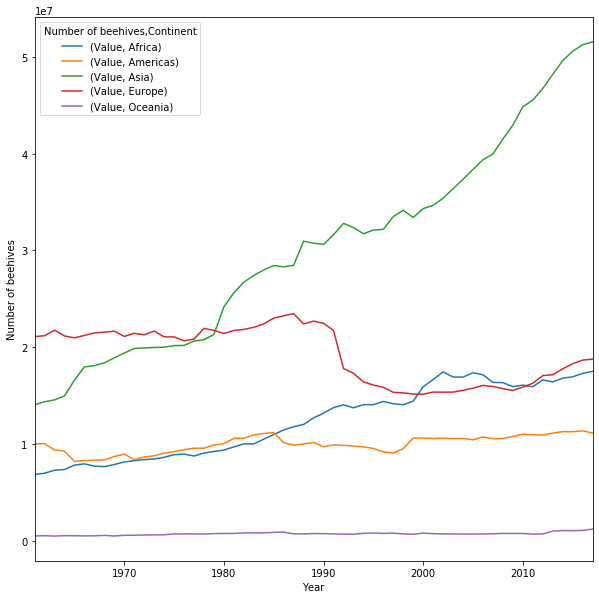

In [8]:
def plot_beehives(df):
    ax = df.plot(kind='line', figsize=(10,10))
    ax.set_ylabel('Number of beehives')
    return ax
    
plot_beehives(beehives);

We can observe the following:

- Asia sees the biggest growth on Earth, surpassing Europe in the 80s.
- Europe saw a sharp decline in the 90s, and recovers slowly since the 2010s.
- Afica does not see any real change since the beggining of the 2000s
- Americas seem to not really evolve in numbers since the beginning.
- It's difficult to tell for Oceania.

That's all well and good, but the most interesting statistic would be to see the derivate of these values. Let's modify our pivot table.

In [9]:
beehives_derivative = beehives.diff() / beehives
# This obviously creates a NaN value for the first year, let's replace it by 0
beehives_derivative = beehives_derivative.fillna(0)

### Europe

Now, let's compute the values for Europe.

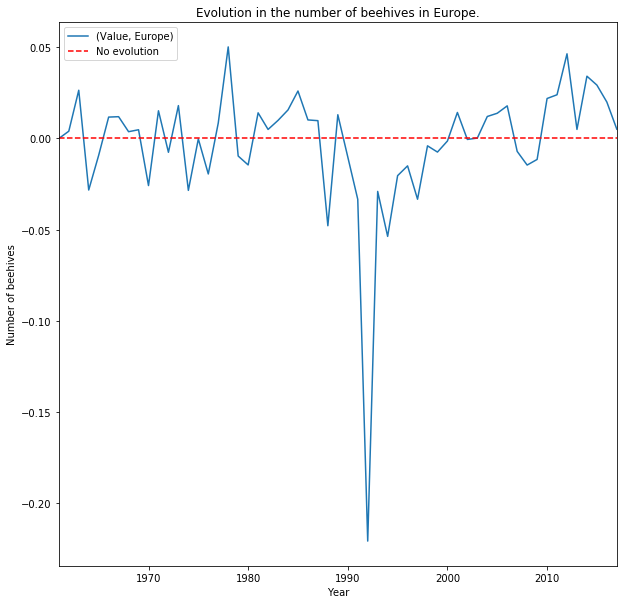

In [10]:
beehives_evol_eur = beehives_derivative[('Value','Europe')]
ax = plot_beehives(beehives_evol_eur)
ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Evolution in the number of beehives in Europe.')
plt.legend();

In [11]:
decrease = abs(beehives_evol_eur.min()*100)
msg = 'Europe saw their worst year in total beehives numbers in %d, where it lost %.1f%% of their count.'
print(msg % (beehives_evol_eur.idxmin(), decrease))

Europe saw their worst year in total beehives numbers in 1992, where it lost 22.1% of their count.


We can see a very sharp decline in 1992. Let's investigate on where it came from, by looking at the individual countries in Europe.

In [12]:
def build_continent(continent):
    continent = beehives_raw[beehives_raw['Continent'] == continent]
    continent = continent.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
    continent.columns.names = ['Number of beehives', 'Country']
    return continent
    

beehives_eur = build_continent('Europe')

beehives_eur_gains = beehives_eur.diff()
beehives_eur_gains = beehives_eur_gains.fillna(0)

beehives_eur_1992 = beehives_eur_gains.loc[1992]
beehives_eur_1992[beehives_eur_1992 < 0.0].sort_values()

Number of beehives  Country       
Value               Bulgaria         -101191.0
                    Czechoslovakia    -97966.0
                    Germany           -47000.0
                    Albania           -36700.0
                    France            -16478.0
                    Sweden            -13000.0
Name: 1992, dtype: float64

We see that there are 6 countries that are the biggest losers in 1992. Let's investigate them.

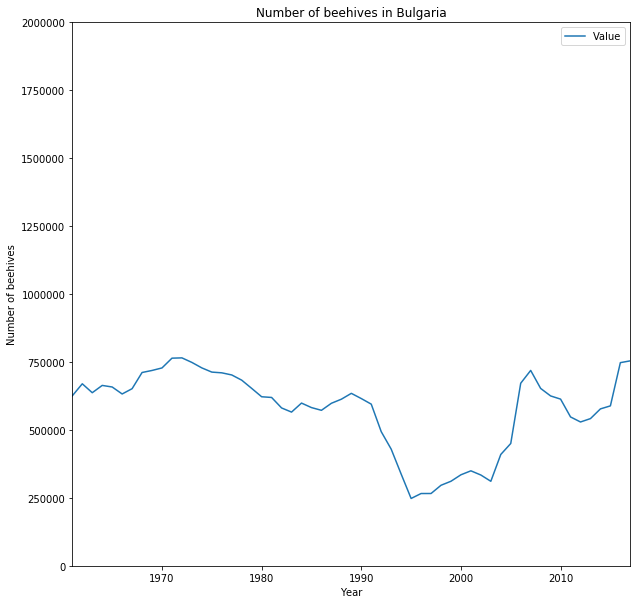

In [13]:
def plot_country(country, top=2e6):
    ax = plot_beehives(beehives_raw[beehives_raw['Area'] == country].set_index('Year'))
    ax.set_title('Number of beehives in %s' % country)
    ax.set_ylim(bottom=0, top=top)
    
plot_country('Bulgaria')

We see that the number of beehives in Bulgaria dropped significantly during the first years of the 90s, and rose again in the mid 00s. This is maybe due to the fall of the Warsaw pact. So this is a legitimate loss for this year.

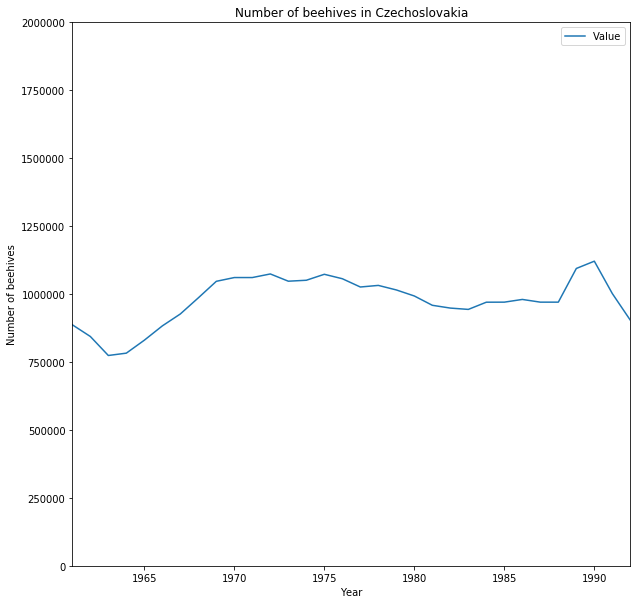

In [14]:
plot_country('Czechoslovakia')

Here, we can see a similar reason than Bulgaria, albeit with a lesser drop. The reason we have no data after 1992 is that the country was split and became Czechia and Slovakia. Let's build the graph as if the country never split.

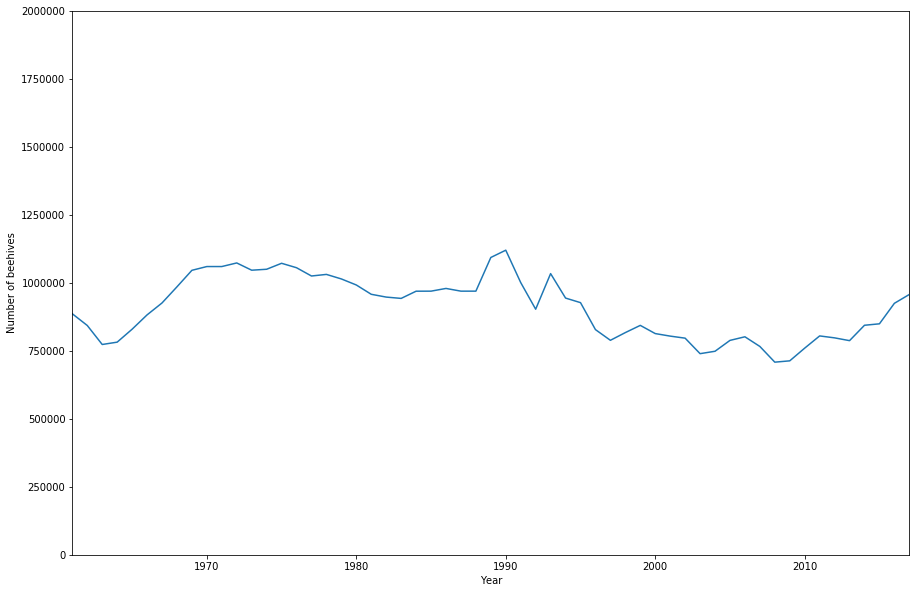

In [15]:
def extract_value(country, year):
    return beehives_raw[beehives_raw['Area'] == country].set_index('Year').loc[year].values[1]

beehives_cshh = beehives_raw[beehives_raw['Area'].isin(['Czechia', 'Slovakia'])]
beehives_cshh = beehives_cshh.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
beehives_cshh.columns.names = ['Number of beehives', 'Country']
beehives_cshh[('Value', 'Czechoslovakia')] = beehives_cshh[('Value', 'Czechia')] + beehives_cshh[('Value', 'Slovakia')]
beehives_cshh = beehives_raw[beehives_raw['Area'] == 'Czechoslovakia'].set_index('Year')['Value'].append(beehives_cshh[('Value', 'Czechoslovakia')])
ax = beehives_cshh.plot(kind='line',figsize=(15,10))
ax.set_ylabel('Number of beehives')
ax.set_ylim(bottom=0, top=2e6);

With this now complete statistic for Czechoslovakia, we see a gloally very similar outcome than what Bulgaria experienced. But the country (-ies) did not manage to come back to their levels of before the fall of communism in Europe, even though the drop was far less impressive than in Bulgaria.

Let's analyse the next in the list, namely Germany.

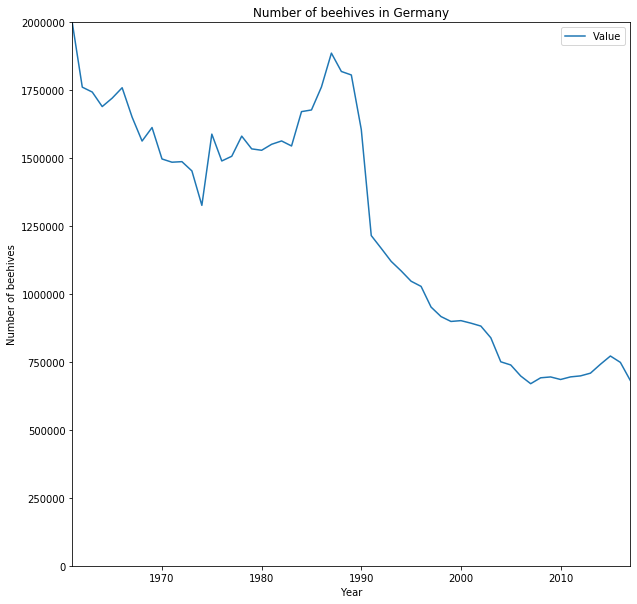

In [16]:
plot_country('Germany')

We also see a significant drop from the beginning of the 90s. Contrary to other countries previously encountered, Germany never came close to its glorious past days. We can suppose that honey was a big factor in Eastern Germany, and since the reunification, it isn't seen as lucrative.

We also note that Germany was a very big "producer" of beehives in 1961, when the statistics began. This is not the case now.

Now, let's see Albania.

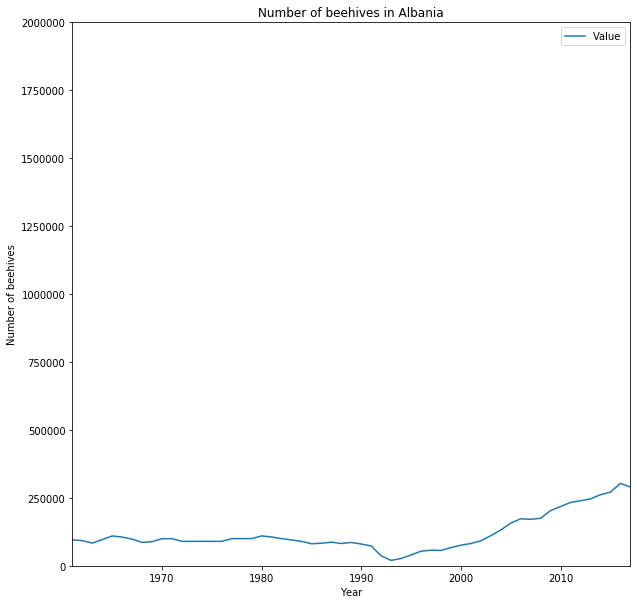

In [17]:
plot_country('Albania')

The wars in the Balkans is probably the cause of this drop. However, after this, the number of beehives grew, whereas it was only stable before these terrible events.

Let's now see France.

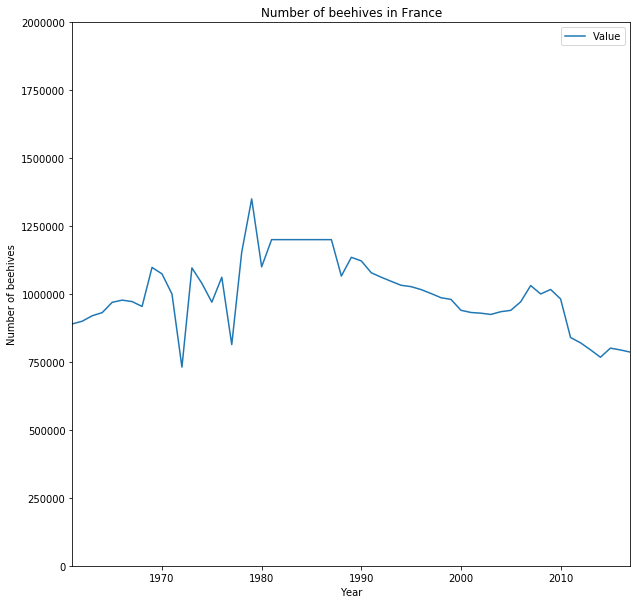

In [18]:
plot_country('France')

It looks like no updated number of beehives were given in the 80s, so the latest value was simply reported for all these years. After the 80s, we see a continuous drop in their numbers, until today, which is one of the lowest recorded numbers for France.

We can see some "glitches" in the 70s, probably due to counting errors. It's unlikely the numbers would have changed so quickly.

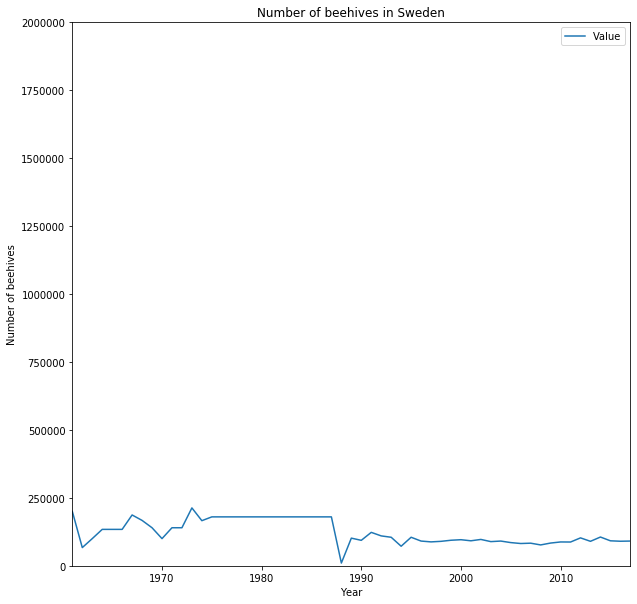

In [19]:
plot_country('Sweden')

The last country on our list, Sweden, sees their number be very stable since the 90s.

Now, let's analyze the recent gains observed in Europe.

In [20]:
beehives_eur_2010s = beehives_eur_gains.loc[beehives_eur_gains.index >= 2010]
beehives_gains_2010s = beehives_eur_2010s.max().sort_values(ascending=False)
beehives_gains_2010s = beehives_gains_2010s[beehives_gains_2010s > 2e5]
beehives_gains_2010s

Number of beehives  Country           
Value               Serbia                358954.0
                    Romania               217731.0
                    Russian Federation    200772.0
dtype: float64

We note that a few countries have known some exceptional years of growth. Let's analyze Serbia, Romania and Russia.

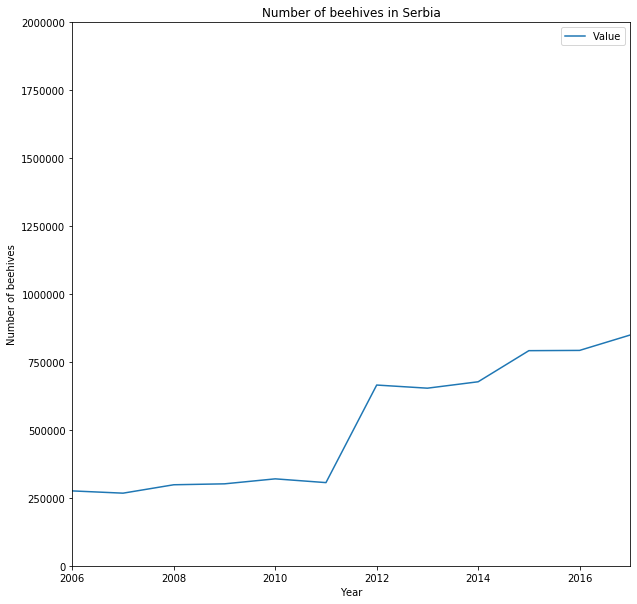

In [21]:
plot_country('Serbia')

Again, Serbia is a fairly new country, since before it was Serbia and Montenegro, and even before, Yugoslavia. But this suffices to see that the grwoth observed in the 2010s is very impressive indeed.

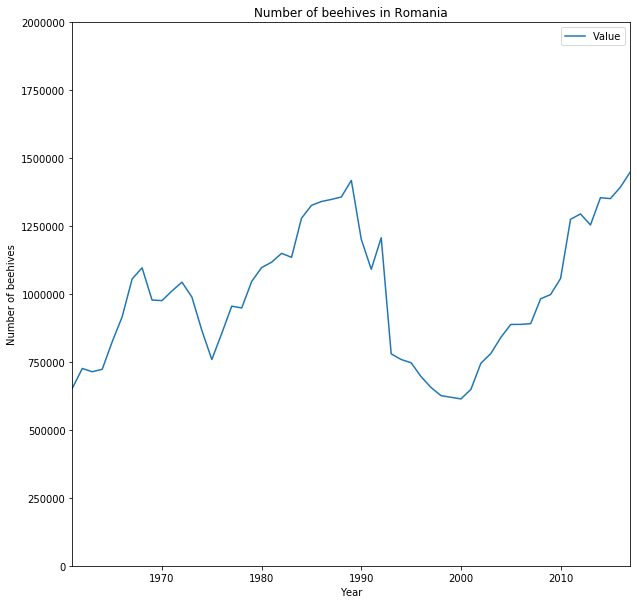

In [22]:
plot_country('Romania')

Here, we have almost a carbon copy of the behavior observed in Bulgaria. Romania just regained the levels at which they were before the fall of the Eastern Bloc.

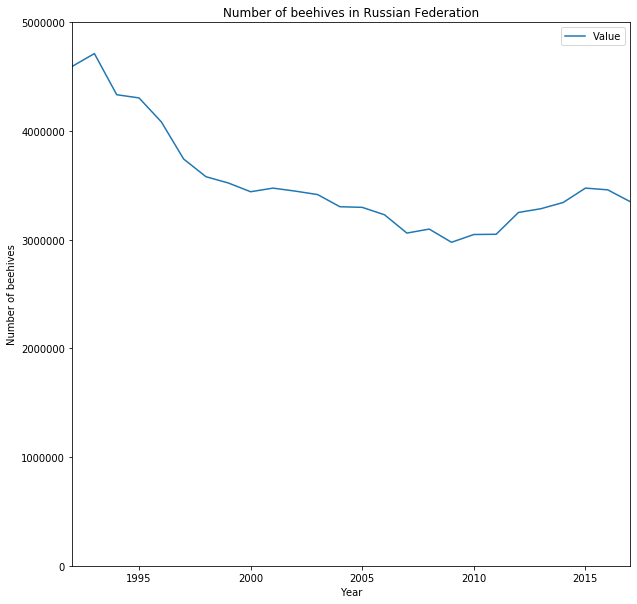

In [23]:
ax = plot_country('Russian Federation', top=5e6)

We see that Russia has an enormous number of beehives. There is a significant drop since the fall of the USSR, which seems nowadays more or less stabilized.

Let's finally see which European countries have the most beehives.

In [24]:
beehives_eur[beehives_eur.index == 2017].iloc[0].sort_values(ascending=False).head(10)

Number of beehives  Country           
Value               Russian Federation    3349976.0
                    Spain                 2904971.0
                    Poland                1589276.0
                    Greece                1561498.0
                    Romania               1449318.0
                    Serbia                 849280.0
                    Hungary                816000.0
                    France                 786172.0
                    Bulgaria               754105.0
                    Germany                681682.0
Name: 2017, dtype: float64

We can conclude this portion of the analysis that the significant drop observed in Europe in the beginning of the 90s was certainly due to the fall of the USSR, and all the economic turmoil it caused.

### Asia

Firstly, let's see the biggest players in Asia.

In [30]:
beehives_asia = build_continent('Asia')
beehives_asia[beehives_asia.index == 2017].iloc[0].sort_values(ascending=False).head(10)

Number of beehives  Country                   
Value               India                         12763684.0
                    China                          9156882.0
                    China, mainland                9031457.0
                    Turkey                         7796666.0
                    Iran (Islamic Republic of)     7271825.0
                    Republic of Korea              1724389.0
                    Syrian Arab Republic            520795.0
                    Uzbekistan                      488200.0
                    Pakistan                        400019.0
                    Viet Nam                        278448.0
Name: 2017, dtype: float64

We see several outliers: India, China (China, mainland and China, Taiwan Province of), Turky and Iran. Let's see their respective evolutions.

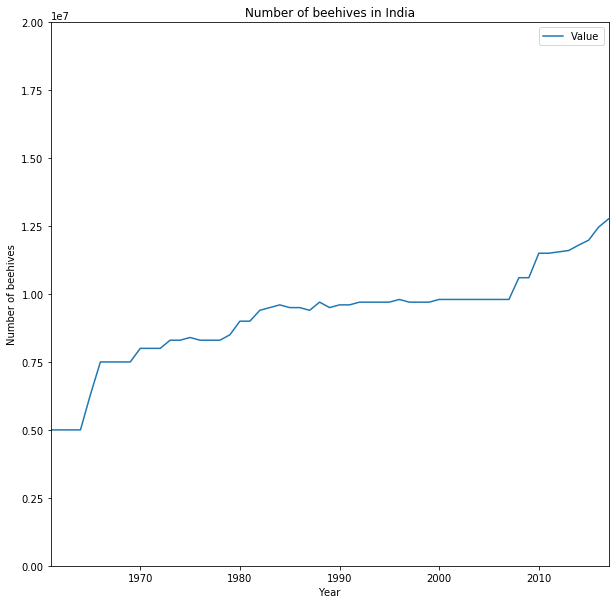

In [26]:
plot_country('India', top=2e7)

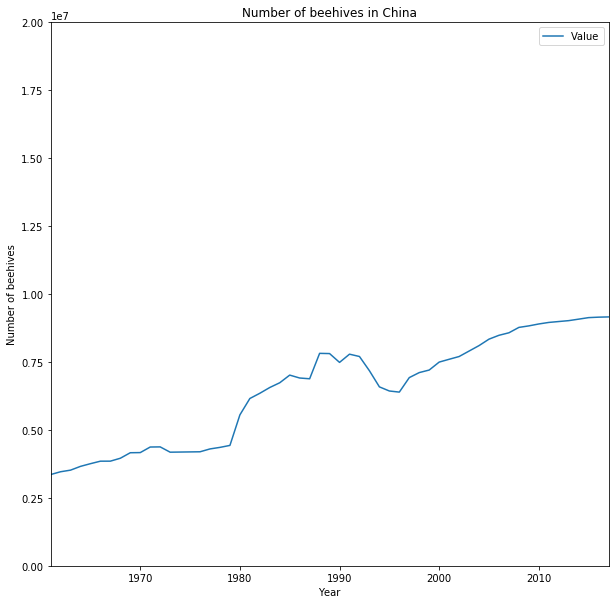

In [27]:
plot_country('China', top=2e7)

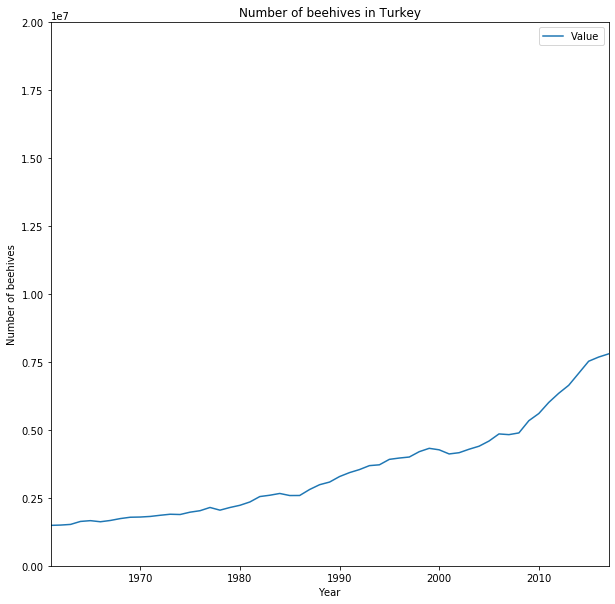

In [28]:
plot_country('Turkey', top=2e7)

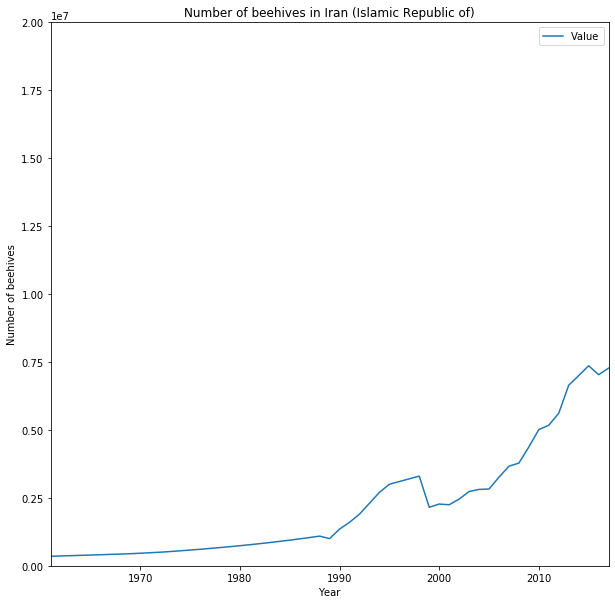

In [29]:
plot_country('Iran (Islamic Republic of)', top=2e7)

The beehive growth in these countries is mainly due to their economic growth, even if we are not sure why Turkey gained such an interest in beehives in the recent years. The global Asian growth can be reduced to the growth of these countries, since their numbers are far beyond any other country in Asia.

### Americas

Since the beehive numbers are stable America, let's plot the biggest producers' history.

In [34]:
beehives_am = build_continent('Americas')
beehives_am[beehives_am.index == 2017].iloc[0].sort_values(ascending=False).head(4)

Number of beehives  Country                 
Value               Argentina                   3003036.0
                    United States of America    2669000.0
                    Mexico                      1853807.0
                    Brazil                      1012692.0
Name: 2017, dtype: float64

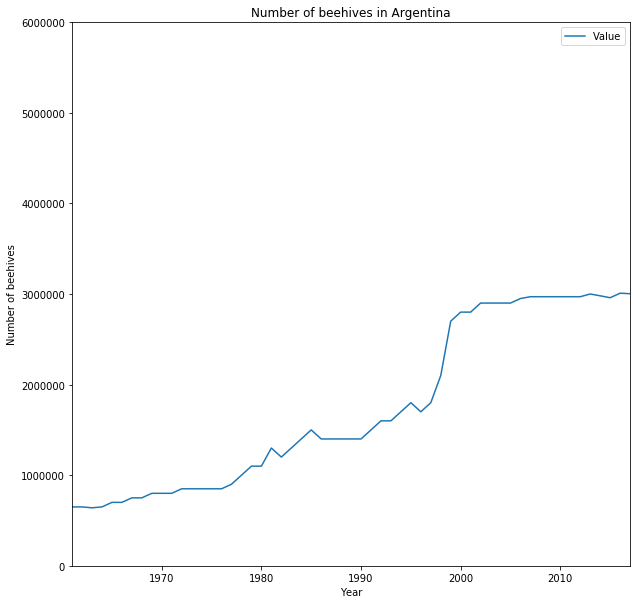

In [43]:
plot_country('Argentina', top=6e6)

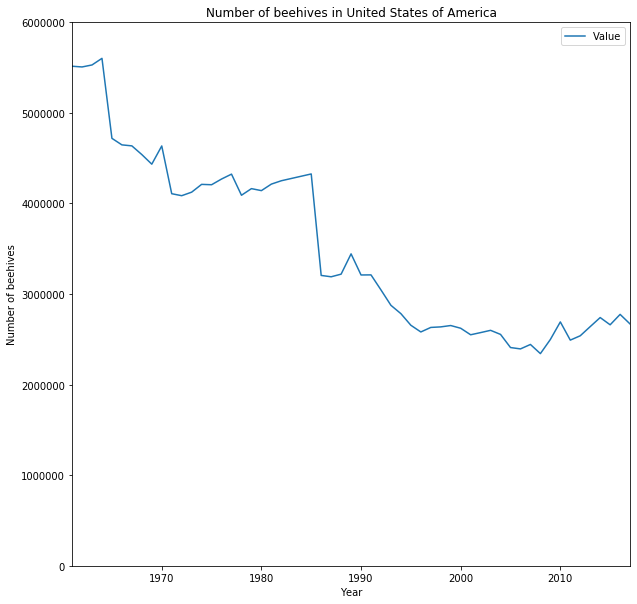

In [42]:
plot_country('United States of America', top=6e6)

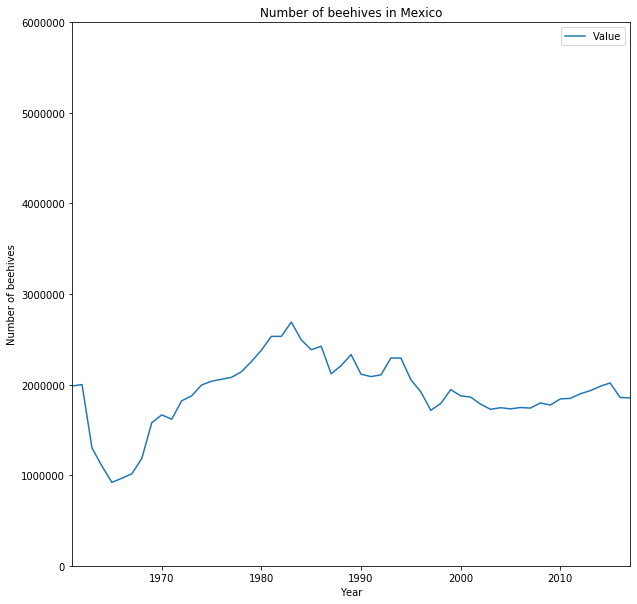

In [44]:
plot_country('Mexico', top=6e6)

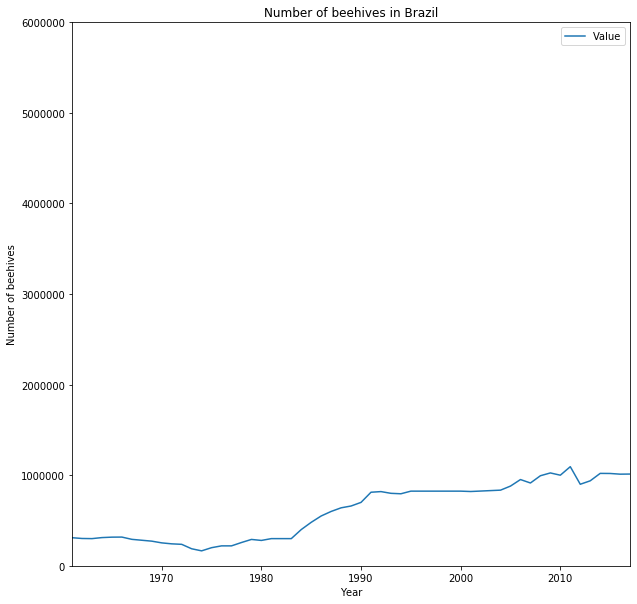

In [45]:
plot_country('Brazil', top=6e6)

We see very different behaviors:
    
- Argentina has the most beehives in the Americas. Their numbers grew at first very quickly, but are stable since ca. 2000.
- The US are second, but had way more beehives in the 60s. Their numbers fell until the mid 90s (they more than halved in this time period!), then stabilized.
- Mexico is overall stable for the period (1961-2017)
- Brazil saw a very big increase in the number of beehives in the 80s, and then stablized their numbers.

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Let's apply the same process to the honey production data than to the number of beehives.

In [53]:
honey_raw = pd.read_csv('data/FAOSTAT_Livestock_Primary.csv')
honey_raw = honey_raw[['Area', 'Year', 'Value']]
honey_raw['Continent'] = honey_raw.apply(lambda row: countries.loc[row['Area']], axis=1)
honey_raw.head()

,Area,Year,Value,Continent
0,Afghanistan,1961,2000.0,Asia
1,Afghanistan,1962,2000.0,Asia
2,Afghanistan,1963,2000.0,Asia
3,Afghanistan,1964,2000.0,Asia
4,Afghanistan,1965,3000.0,Asia


Let's check if we have the same countries as for the number of beehives.

In [83]:
honey_countries_eur = honey_raw[honey_raw['Continent'] == 'Europe']['Area'].value_counts().keys()
beehives_countries_eur = beehives_raw[beehives_raw['Continent'] == 'Europe']['Area'].value_counts().keys()
print(set(honey_countries_eur).symmetric_difference(set(beehives_countries_eur)))
print(set(honey_countries_eur) - set(beehives_countries_eur))

{'Norway', 'Ireland', 'Denmark'}
{'Ireland', 'Norway', 'Denmark'}


We see that we do not have any beehive numbers for Denmark, Ireland and Norway. Let's see what percentage of the European honey production they make up in 2017.

In [100]:
honey_prod_eur = honey_eur.loc[2017]['Value']['Europe']
honey_prod_2017 = honey_raw[honey_raw['Year'] == 2017]
honey_prod_den = honey_prod_2017[honey_prod_2017['Area'] == 'Denmark']['Value'].values[0]
honey_prod_eir = honey_prod_2017[honey_prod_2017['Area'] == 'Ireland']['Value'].values[0]
honey_prod_nor = honey_prod_2017[honey_prod_2017['Area'] == 'Norway']['Value'].values[0]
proportion = (honey_prod_den + honey_prod_eir + honey_prod_nor) / honey_prod_eur
print('Denmark, Ireland and Norway make up %f%% of the European honey production.' % (proportion * 100))

Denmark, Ireland and Norway make up 0.102713% of the European honey production.


These 3 countries make up less than one thousandth of the total European honey production, so we can safely drop them from the dataset.

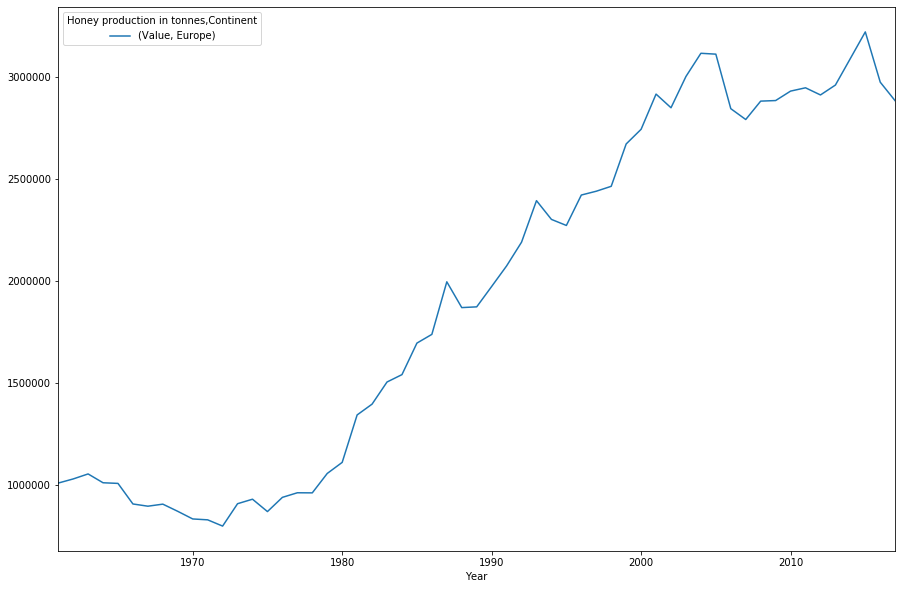

In [101]:
honey_eur = honey_raw[honey_raw['Continent'] == 'Europe']
honey_eur = honey_eur[honey_eur['Area'].isin(beehives_countries_eur)].drop('Area', 1)
honey_eur = honey_eur.pivot_table(index=['Year'], columns=['Continent'], aggfunc=np.sum)
honey_eur.columns.names = ['Honey production in tonnes', 'Continent']
honey_eur.plot(kind='line',figsize=(15,10))

Here, we already see a major difference with respects to what we observed with the number of beehives. Honey production did not stop growing in the 90s, even though there was a big drop in the number of beehives.

Let's plot the differences between each year for both honey and beehives.

In [130]:
honey_derivative = honey_eur.diff() / honey_eur
honey_derivative = honey_derivative.fillna(0)[('Value', 'Europe')]

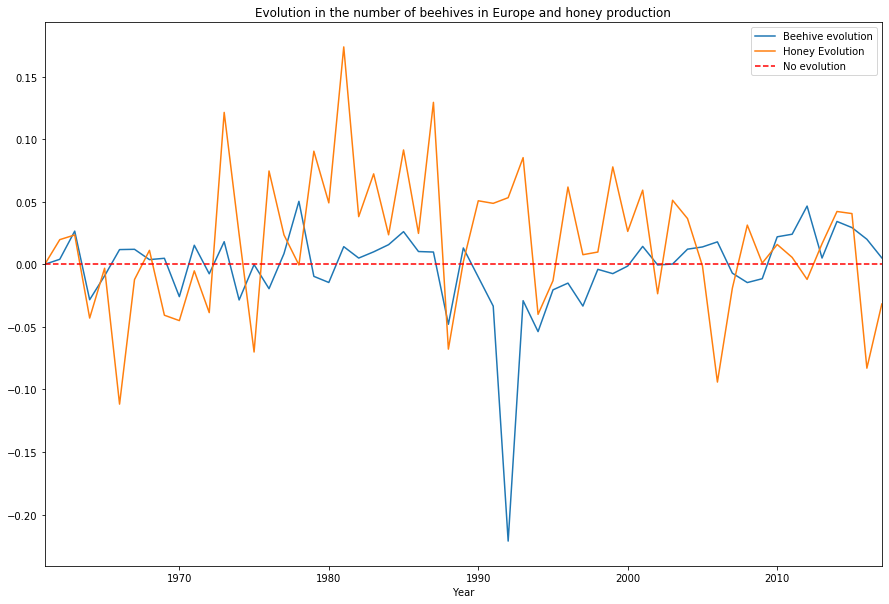

In [131]:
ax = beehives_evol_eur.plot(kind='line', figsize=(15,10), label='Beehive evolution')
honey_derivative.plot(ax=ax, label='Honey Evolution')

ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Evolution in the number of beehives in Europe and honey production')
plt.legend();

0.019432497841038638


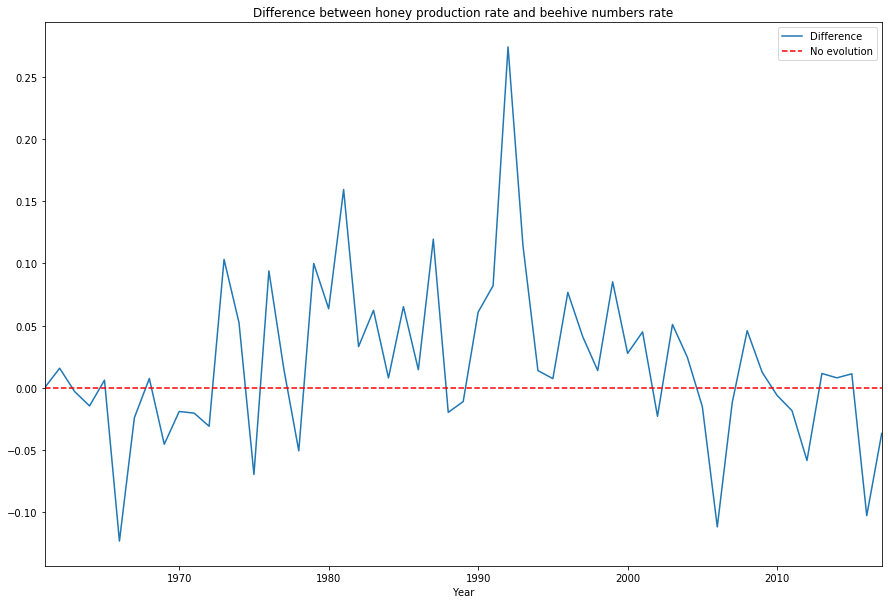

In [151]:
eur_diff = honey_derivative - beehives_evol_eur
ax = eur_diff.plot(kind='line', figsize=(15,10), label='Difference')
ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Difference between honey production rate and beehive numbers rate')
plt.legend();
print(eur_diff.mean())

On this last series of graphs, we can see that the rate of honey production is very often superior to the one of the number of beehives. This can mean that producers are more efficient with lesser numbers of beehives.

Let's do the same thing with the US.

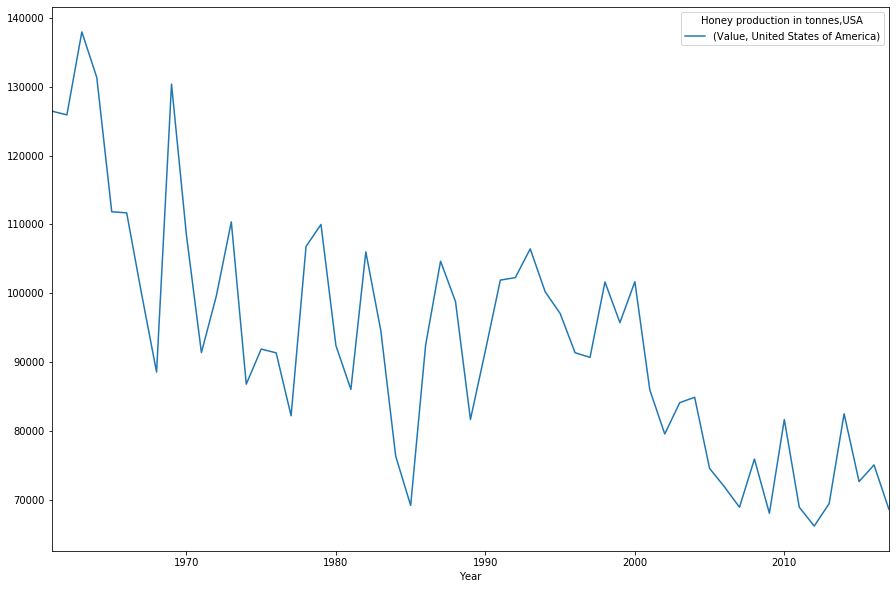

In [141]:
honey_us = honey_raw[honey_raw['Area'] == 'United States of America'].drop('Continent', 1)
honey_us = honey_us.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
honey_us.columns.names = ['Honey production in tonnes', 'USA']
honey_us.plot(kind='line',figsize=(15,10))

Here, on the contrary, we rather confirm that the US have far fewer beehives.

In [143]:
honey_us_derivative = honey_us.diff() / honey_us
honey_us_derivative = honey_us_derivative.fillna(0)[('Value', 'United States of America')]

In [148]:
beehives_evol_us = beehives_raw.drop('Continent', 1)
beehives_evol_us = beehives_evol_us[beehives_evol_us['Area'] == 'United States of America']
beehives_evol_us = beehives_evol_us.pivot_table(index=['Year'], columns=['Area'], aggfunc=np.sum)
beehives_evol_us.columns.names = ['Number of beehives', 'Country']

beehives_evol_us = beehives_evol_us.diff() / beehives_evol_us
beehives_evol_us = beehives_evol_us.fillna(0)[('Value', 'United States of America')]

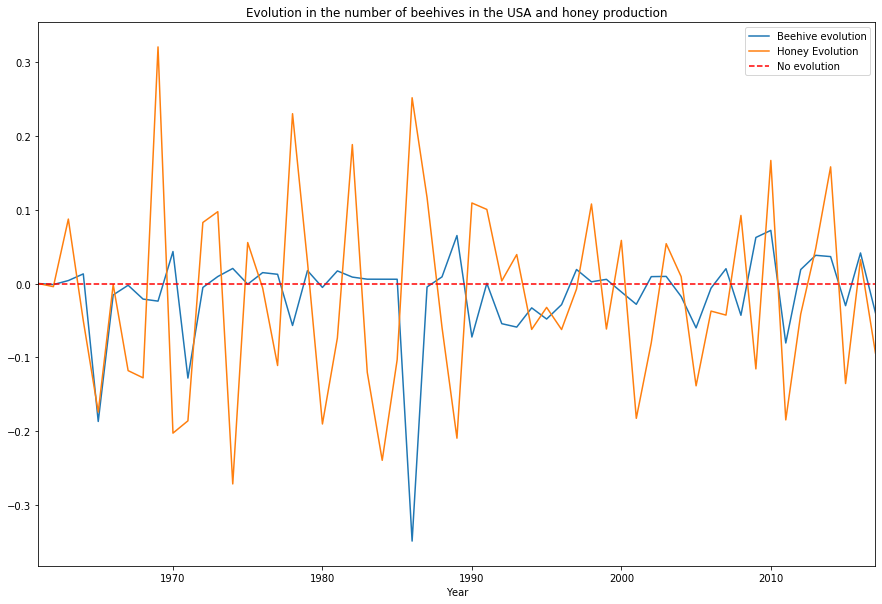

In [149]:
ax = beehives_evol_us.plot(kind='line', figsize=(15,10), label='Beehive evolution')
honey_us_derivative.plot(ax=ax, label='Honey Evolution')

ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Evolution in the number of beehives in the USA and honey production')
plt.legend();

-0.004672386681994503


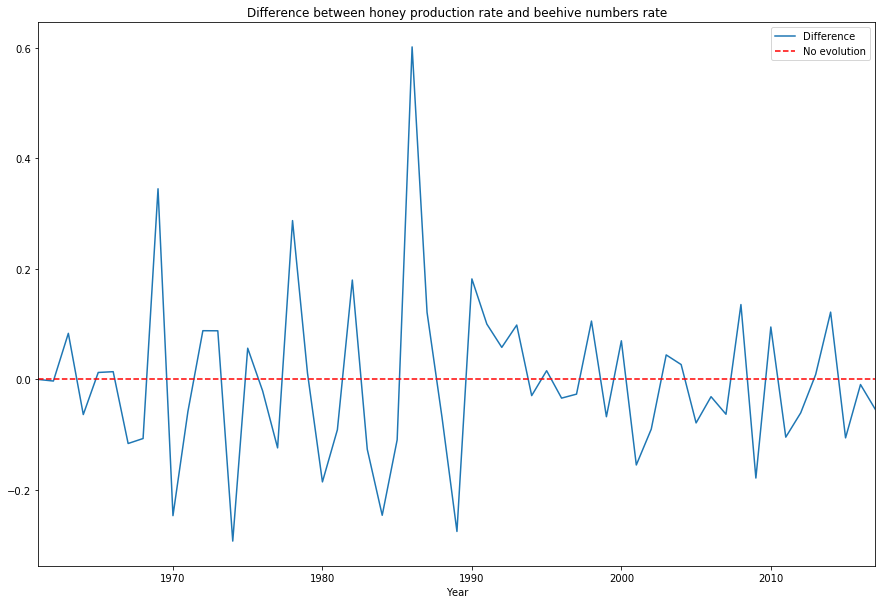

In [152]:
us_diff = honey_us_derivative - beehives_evol_us
ax = us_diff.plot(kind='line', figsize=(15,10), label='Difference')
ax.axhline(y=0.0, color='red', linestyle='--', label='No evolution')
ax.set_title('Difference between honey production rate and beehive numbers rate')
plt.legend();
print(us_diff.mean())

Here, contrary to Europe, we even see an overall mean that is negative, meaning that honey production drops (on a year-by-year basis) more than the number of beehives, or that it grows less.

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

## 4. What is the relation between US cases of Colony Collapse Disorder and the main factors of CCD?

Arthur

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Tim & Arthur